In [3]:
import torch
print(torch.__version__)

2.5.0+cpu


## PROBLEM 1: Setup a tensor library

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False,parser='auto')
X_mnist = mnist.data.astype(float)
X_mnist = X_mnist / 255.0
y_mnist = mnist.target.astype(int)

subset = 10000
indices = np.random.choice(X_mnist.shape[0], size=subset, replace=False)
X_mnist_sub = X_mnist[indices]
y_mnist_sub = y_mnist[indices]
X_train, X_test, y_train, y_test = train_test_split(
    X_mnist_sub, y_mnist_sub, test_size=0.2, random_state=42
)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        # Compute the size after two poolings:
        # MNIST images are 28x28. After first pooling: 14x14, then after second: 7x7.
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Final layer for 10 classes
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))  # (batch, 32, 28, 28)
        x = self.pool(x)              # (batch, 32, 14, 14)
        x = self.relu(self.conv2(x))  # (batch, 64, 14, 14)
        x = self.pool(x)              # (batch, 64, 7, 7)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)     # flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)               # logits output
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Check for GPU and move model if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Evaluate on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    test_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/5], Loss: 1.7409, Test Accuracy: 79.35%
Epoch [2/5], Loss: 0.4641, Test Accuracy: 90.95%
Epoch [3/5], Loss: 0.2694, Test Accuracy: 93.95%
Epoch [4/5], Loss: 0.1765, Test Accuracy: 95.55%
Epoch [5/5], Loss: 0.1388, Test Accuracy: 96.20%


## PROBLEM 2 : NNet supervised classification with tuned word vectors

In [5]:
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.utils import simple_preprocess
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np


In [7]:
# Load GloVe embeddings with 100 dimensions
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    glove = f.read().strip().split('\n')

In [8]:
glove_embeddings = {}
for text in glove:
    word = text.split(' ')[0]
    vec = np.array([float(val) for val in text.split(' ')[1:]])
    glove_embeddings[word] = vec

In [6]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data
y_newsgroups = newsgroups.target

vectorizer = TfidfVectorizer(max_features=10000)
X_newsgroups = vectorizer.fit_transform(texts)
subset = 10000
indices = np.random.choice(len(texts), size=subset, replace=False)
texts_sub = [texts[i] for i in indices]
labels_sub = np.array(y_newsgroups)[indices]

In [9]:
vocab = set()
for text in texts_sub:
    tokens = simple_preprocess(text) #lowercasing, tokenize, remove punctuation, filter by length
    for word in tokens:
        # Keep only words that are in GloVe
        if word in glove_embeddings.keys():        
            vocab.add(word)
            
word2idx = {word: i+1 for i, word in enumerate(vocab)}

In [10]:
embedding_dim = 100
vocab_size = len(word2idx) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word2idx.items():
    embedding_matrix[idx] = glove_embeddings[word]

In [11]:
def doc2ind(doc):
    """Tokenizes a document and converts tokens to indices"""
    tokens = simple_preprocess(doc)
    return [word2idx[token] for token in tokens if token in word2idx]
    
# Convert documents to sequences of indices
sequences = [doc2ind(doc) for doc in texts_sub]

In [45]:
import pandas as pd
pd.Series(sequences).apply(len).describe()  # Check the length distribution

count    10000.000000
mean       165.468000
std        494.138338
min          0.000000
25%         36.000000
50%         74.000000
75%        149.250000
max      11557.000000
dtype: float64

In [12]:
def pad_sequence(seq, max_len=500):
    """
    Pad (or truncate) a list of indices to a fixed max length
    To make all the sequence/documents/context the same length for NN input
    """
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

padded_sequences = [pad_sequence(seq) for seq in sequences]

# Convert to torch tensors
X_tensor = torch.LongTensor(padded_sequences)
y_tensor = torch.LongTensor(labels_sub)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [14]:
class NewsgroupsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = NewsgroupsDataset(X_train, y_train)
test_dataset = NewsgroupsDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [15]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, embedding_dim=100, freeze=False):
        super(TextClassifier, self).__init__()
        
        # Create an embedding layer from a pre-trained matrix (e.g., GloVe).
        # Set `freeze=True` to keep embeddings fixed during training.
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            freeze=freeze
        )
        
        # First fully connected (dense) layer: maps embedding_dim → 256
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.relu = nn.ReLU()  # ReLU activation function
        # Output layer: maps 256 → number of classes
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x shape: (batch_size, max_seq_length)
        
        embeds = self.embedding(x)  # shape: (batch_size, max_len, embedding_dim)
        
        # Average the embeddings across the sequence length (mean pooling)
        pooled = torch.mean(embeds, dim=1)  # shape: (batch_size, embedding_dim)
        
        out = self.fc1(pooled)  # Pass through first dense layer
        out = self.relu(out)    # Apply ReLU activation
        out = self.fc2(out)     # Output layer for classification
        return out              # shape: (batch_size, num_classes)


In [18]:
num_classes = len(set(y_tensor.numpy()))  # Number of unique classes
# 1) Frozen Embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running with frozen embeddings...")
model_frozen = TextClassifier(embedding_matrix, num_classes, freeze=True)
accuracy_frozen = train_and_evaluate(model_frozen, train_loader, test_loader, device, epochs=10)
frozen_embeddings = model_frozen.embedding.weight.data[1:,:].cpu().numpy().copy() # Exclude padding index 0
# 2) Fine-Tuned Embeddings
print("\nRunning with fine-tuned embeddings...")
model_finetuned = TextClassifier(embedding_matrix, num_classes, freeze=False)
accuracy_finetuned = train_and_evaluate(model_finetuned, train_loader, test_loader, device, epochs=30)
fine_tuned_embeddings = model_finetuned.embedding.weight.data[1:,:].cpu().numpy().copy()

Running with frozen embeddings...
Epoch [1/10], Loss: 2.9449
Epoch [2/10], Loss: 2.8085
Epoch [3/10], Loss: 2.6381
Epoch [4/10], Loss: 2.4803
Epoch [5/10], Loss: 2.3578
Epoch [6/10], Loss: 2.2623
Epoch [7/10], Loss: 2.1852
Epoch [8/10], Loss: 2.1195
Epoch [9/10], Loss: 2.0628
Epoch [10/10], Loss: 2.0176
Test Accuracy: 39.65%

Running with fine-tuned embeddings...
Epoch [1/30], Loss: 2.9425
Epoch [2/30], Loss: 2.7793
Epoch [3/30], Loss: 2.5127
Epoch [4/30], Loss: 2.2705
Epoch [5/30], Loss: 2.0851
Epoch [6/30], Loss: 1.9265
Epoch [7/30], Loss: 1.7914
Epoch [8/30], Loss: 1.6717
Epoch [9/30], Loss: 1.5582
Epoch [10/30], Loss: 1.4576
Epoch [11/30], Loss: 1.3730
Epoch [12/30], Loss: 1.2813
Epoch [13/30], Loss: 1.2046
Epoch [14/30], Loss: 1.1306
Epoch [15/30], Loss: 1.0656
Epoch [16/30], Loss: 1.0030
Epoch [17/30], Loss: 0.9462
Epoch [18/30], Loss: 0.8869
Epoch [19/30], Loss: 0.8368
Epoch [20/30], Loss: 0.7905
Epoch [21/30], Loss: 0.7445
Epoch [22/30], Loss: 0.7056
Epoch [23/30], Loss: 0.6662

In [20]:
import umap

In [28]:
umap_model = umap.UMAP(n_components=2)
initial_embeds_2d = umap_model.fit_transform(frozen_embeddings)  
test_proj_initial = umap_model.transform(X_test) 

In [30]:
umap_model_fine_tune = umap.UMAP(n_components=2)
doc_embeds_2d = umap_model_fine_tune.fit_transform(fine_tuned_embeddings) 
test_proj_doc = umap_model_fine_tune.transform(X_test) 

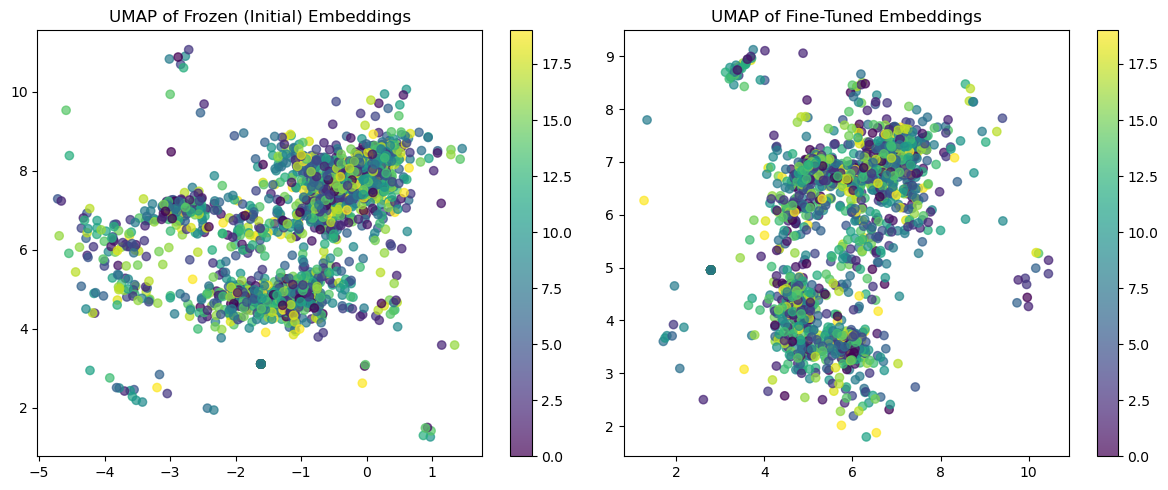

In [31]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sc1 = plt.scatter(test_proj_initial[:, 0], test_proj_initial[:, 1], c=y_test, alpha=0.7)
plt.title("UMAP of Frozen (Initial) Embeddings")
plt.colorbar(sc1)

plt.subplot(1, 2, 2)
sc2 = plt.scatter(test_proj_doc[:, 0], test_proj_doc[:, 1], c=y_test, alpha=0.7)
plt.title("UMAP of Fine-Tuned Embeddings")
plt.colorbar(sc2)

plt.tight_layout()
plt.show()